In [1]:
import os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
os.chdir('/Users/rraj/PythonFunctions/DCNet/')
os.getcwd()

'/Users/rraj/PythonFunctions/DCNet'

In [2]:
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
from tqdm import tqdm

mnist_data = MNIST(
    root = 'data',
    train = True,                         
    transform = transforms.ToTensor(), 
    download = True,            
)

mnist_test_data = MNIST(
    root = 'data',
    train = False,                         
    transform = transforms.ToTensor(), 
    download = True,            
)

In [3]:
from torch import nn

class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 6, 5, padding=2),
            nn.Sigmoid(),
            nn.AvgPool2d(2, stride=2),
            nn.Conv2d(6, 16, 5),
            nn.Sigmoid(),
            nn.AvgPool2d(2, stride=2),
            nn.Flatten(),
            nn.Linear(400, 120),
            nn.Sigmoid(),
            nn.Linear(120, 84),
            nn.Sigmoid(),
            nn.Linear(84, 10)
        )
    def forward(self, x):
        return self.net(x)

In [4]:
from torch.utils.data import DataLoader, Dataset, RandomSampler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LeNet().to(device)

nepochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loader = DataLoader(mnist_data, batch_size=64, sampler=RandomSampler(mnist_data))
loss_fn = torch.nn.CrossEntropyLoss()

In [5]:
import torch.nn.functional as F
from tqdm import tqdm

running_loss = 0
for epoch in range(nepochs):
    for i, data in tqdm(enumerate(loader), total=len(loader), desc=f"Epoch:{epoch+1}/{nepochs}"):
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        preds = model(inputs)
        loss = loss_fn(preds, targets)
        loss.backward()
        optimizer.step()
        
        running_loss = loss.item()
    print(f"{running_loss=:.3f}")



Epoch:1/10: 100%|██████████| 938/938 [00:14<00:00, 63.48it/s]


running_loss=0.196


Epoch:2/10: 100%|██████████| 938/938 [00:14<00:00, 64.51it/s]


running_loss=0.500


Epoch:3/10: 100%|██████████| 938/938 [00:14<00:00, 65.33it/s]


running_loss=0.062


Epoch:4/10: 100%|██████████| 938/938 [00:14<00:00, 65.35it/s]


running_loss=0.099


Epoch:5/10: 100%|██████████| 938/938 [00:14<00:00, 65.45it/s]


running_loss=0.163


Epoch:6/10: 100%|██████████| 938/938 [00:14<00:00, 65.65it/s]


running_loss=0.138


Epoch:7/10: 100%|██████████| 938/938 [00:14<00:00, 64.56it/s]


running_loss=0.034


Epoch:8/10: 100%|██████████| 938/938 [00:14<00:00, 64.76it/s]


running_loss=0.042


Epoch:9/10: 100%|██████████| 938/938 [00:14<00:00, 62.57it/s]


running_loss=0.127


Epoch:10/10: 100%|██████████| 938/938 [00:14<00:00, 65.13it/s]

running_loss=0.146


In [6]:
test_loader = DataLoader(mnist_test_data, shuffle=True)
correct = 0
with torch.no_grad():
    for input, target in test_loader:
        input = input.to(device)
        target = target.to(device)
        prediction = model(input)
        
        if target.item() == prediction.argmax().item():
            correct += 1

print(f"correct={correct/len(test_loader)}")

correct=0.9824


In [7]:
from typing import List

class ActivationExtractor(nn.Module):
    def __init__(self, model: nn.Module, layers: List[int]):
        super().__init__()
        self.model = model
        self.layers = layers
        self._activations = {layer: torch.empty(0) for layer in layers}
        
        for layer in layers:
            self.model.net[layer].register_forward_hook(self._get_activation(layer))
        
    def _get_activation(self, layer: int):
        def hook(_, __, output):
            self._activations[layer] = output.detach()
                
        return hook
    
    def forward(self, x: torch.Tensor):
        self.model(x)
        return self._activations

In [8]:
monitored_layers = [6, 7, 9, 11]
layer_dims = {6: 400, 7: 120, 9: 84, 11: 10}

activations = {layer: torch.empty(0) for layer in monitored_layers}
activation = ActivationExtractor(model, layers=monitored_layers)
test_loader = DataLoader(mnist_test_data, shuffle=True)
targets = []
with torch.no_grad():
    for input, target in tqdm(test_loader, total=len(test_loader)):
        input = input.to(device)
        targets.append(target.item())
        act = activation(input)
        for layer in monitored_layers:
            activations[layer] = torch.cat((activations[layer], act[layer]), dim=0)
        


100%|██████████| 10000/10000 [00:39<00:00, 250.91it/s]


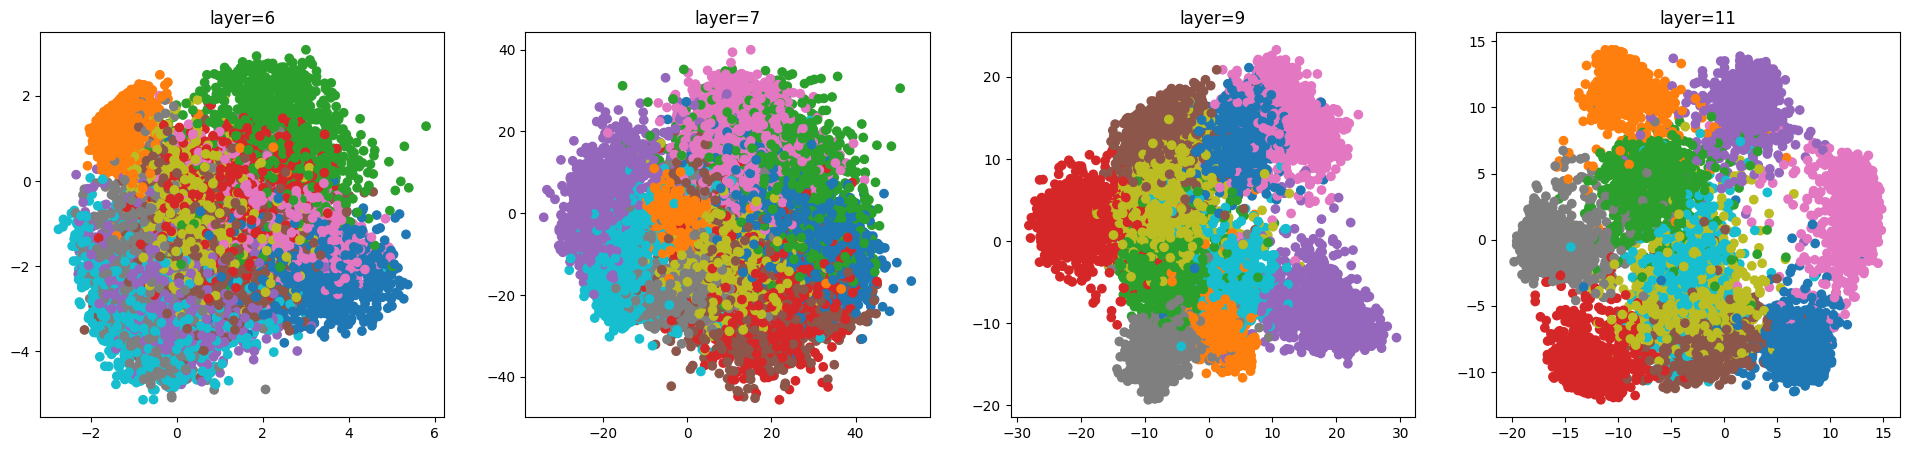

In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

fig, ax = plt.subplots(1, 4, figsize=(24, 5))
for idx, layer in enumerate(monitored_layers):
    pca.fit(activations[layer].numpy())
    components = torch.tensor(pca.components_)
    projection = torch.mm(activations[layer], components.T)

    ax[idx].scatter(projection[:,0], projection[:,1], c=targets, cmap='tab10')
    ax[idx].set_title(f"{layer=}")

In [10]:
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from IPython.display import clear_output, display


class ProjectionPlotter:
    def __init__(self):
        self.fig = plt.figure(figsize=(18,5))
        self.ax1 = self.fig.add_subplot(1, 3, 1)
        self.ax2 = self.fig.add_subplot(1, 3, 2)
        self.ax3 = self.fig.add_subplot(1, 3, 3)
        self.pca = PCA(n_components=2)
        self.loss = []
        
        
    def __call__(self, weights: torch.Tensor, activations: torch.Tensor, targets: List[int], loss: int):
        self.loss.append(loss)
        projections_ref = self._transform(activations)
        
        activations_ = torch.mm(activations, weights)
        activations_ = torch.max(activations_, torch.zeros_like(activations_))
        projections_cur = self._transform(activations_)
        self._draw_fig(projections_ref, projections_cur, targets)
    
    def _transform(self, data: torch.Tensor):
        self.pca.fit(data.numpy())
        components = torch.tensor(self.pca.components_)
        projections = torch.mm(data, components.T)
        return projections
    
    def _draw_fig(self, projections_ref: torch.Tensor, projections_cur: torch.Tensor, targets: List[int]):
        self.ax1.clear()
        self.ax2.clear()
        self.ax3.clear()
        
        self.ax1.scatter(projections_ref[:,0], projections_ref[:,1], c=targets, cmap='tab10')
        self.ax2.scatter(projections_cur[:,0], projections_cur[:,1], c=targets, cmap='tab10')
        self.ax3.plot(self.loss)
        
        clear_output(wait=True)
        display(self.fig)
        
    

In [11]:
import transformations
from transformations import Scale, Identity, ToVector
from loading import TripletLoader

triplet_loader = TripletLoader(mnist_data, transforms=Identity())


In [13]:
from learning import AdaptationOrganizer

layer = 7
layer_dim = 120

nepochs = 100
nbatches = 200
batch_size = 64

plotter = ProjectionPlotter()
organizer = AdaptationOrganizer(layer_dim, lr=0.001, margin=1.0)
transform = ToVector()

#weights = torch.randn(layer_dim, layer_dim)
weights = torch.eye(layer_dim)
for epoch in range(nepochs):
    batch_loss = 0
    for batches in tqdm(range(nbatches), desc=f"Epoch:{epoch+1}/{nepochs}"):
        for x in triplet_loader(batch_size):
            x = x.unsqueeze(0).to(device)
            emb_x = torch.mm(activation(x)[layer], weights)
            emb_x = torch.max(emb_x, torch.zeros_like(emb_x))
            organizer.step(activation(x)[layer], emb_x)
        weights, loss = organizer.organize(weights)
        batch_loss += loss/batch_size
    plotter(weights, activations[layer], targets, batch_loss)
    #clear_output()

Epoch:1/100:   2%|▏         | 3/200 [00:03<03:57,  1.21s/it]

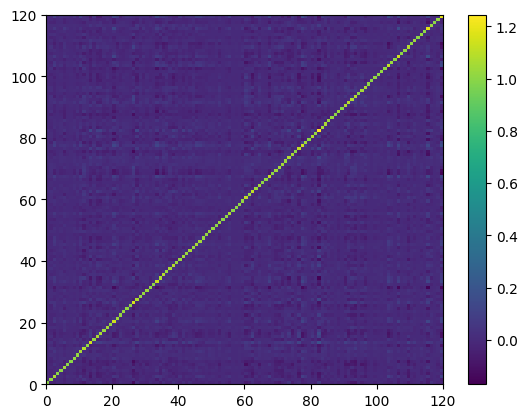

In [15]:
plt.pcolormesh(weights)
plt.colorbar()

In [25]:
from layers import DiscriminationModule, AdaptationModule
from initialization import DatasetInitializer, RandomInitializer
from loading import SequentialLoader

transform = transformations.Compose([Scale(), ToVector()])
triplet_loader_dc = TripletLoader(mnist_data, transforms=transform)
#loader = SequentialLoader(mnist_data, transforms=transform)

layer1 = DiscriminationModule(500, DatasetInitializer(mnist_data, transforms=transform), beta=0.98)
layer2 = AdaptationModule(500, RandomInitializer(500))

In [26]:
nbatches = 100
batch_size = 64
for _ in tqdm(range(nbatches)):
    for x in triplet_loader_dc(batch_size):
        x = layer1(x)
        x = layer2(x)
    layer1.organize()
    layer2.organize()

100%|██████████| 100/100 [1:00:27<00:00, 36.27s/it]


In [28]:
nepochs = 1
nbatches = 100
batch_size = 64
lr = 0.01

weights = torch.randn(500, 500)

for epoch in range(nepochs):
    for batches in tqdm(range(nbatches), desc=f"Epoch:{epoch+1}/{nepochs}"):
        grad = torch.zeros(500, 500)
        for triplet in triplet_loader_dc(batch_size):
            anc = triplet[0]
            pos = triplet[1]
            neg = triplet[2]
            
            emb_anc = dcnet(anc)
            emb_pos = dcnet(pos)
            emb_neg = dcnet(neg)
            
            grad += siamese_grad(weights, [emb_anc, emb_pos, emb_neg])
        weights += lr*grad/batch_size

Epoch:1/1: 100%|██████████| 100/100 [58:19<00:00, 34.99s/it]


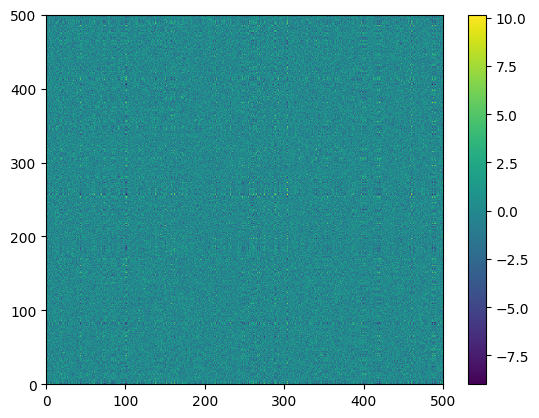

In [29]:
plt.pcolormesh(weights)
plt.colorbar()

In [30]:
test_loader = DataLoader(mnist_test_data, shuffle=True)
targets = []
activations = torch.empty(0)
transformed_activations = torch.empty(0)
for idx, data in tqdm(enumerate(test_loader), total=len(test_loader)):
        input, target = data
        targets.append(target.item())
        input = transform(input)
        output = dcnet(input)
        tranformed_output = torch.mm(output, weights)
        activations = torch.cat((activations, output), dim=0)
        transformed_activations = torch.cat((transformed_activations, tranformed_output), dim=0)
        
        if idx >= 2000:
                break        

 20%|██        | 2000/10000 [06:16<25:06,  5.31it/s]  


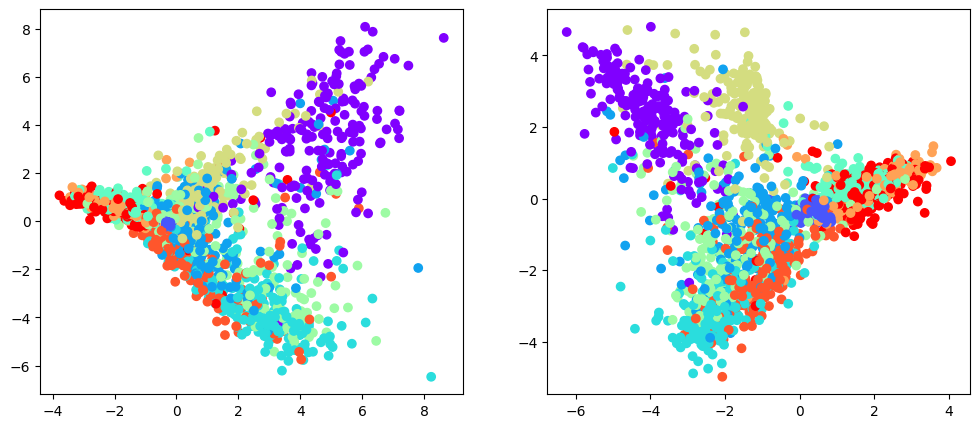

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

pca.fit(activations.numpy())
components = torch.tensor(pca.components_)
projection = torch.mm(activations, components.T)
ax[0].scatter(projection[:,0], projection[:,1], c=targets, cmap='rainbow')

pca.fit(transformed_activations.numpy())
components = torch.tensor(pca.components_)
projection = torch.mm(activations, components.T)
ax[1].scatter(projection[:,0], projection[:,1], c=targets, cmap='rainbow')

In [44]:
import torch
z = torch.randn(5, 5)
x = torch.tensor([True]*5)
print(x.shape)
for i in range(2):
    y = torch.rand(1,5)
    print(f"{y=}")
    x = x.logical_and(y>0.5)
print(f"{x=}")
z = x.T*z
print(f"{z=}")

torch.Size([5])
y=tensor([[0.5585, 0.6034, 0.6698, 0.8414, 0.0723]])
y=tensor([[0.2456, 0.5308, 0.5165, 0.7227, 0.0877]])
x=tensor([[False,  True,  True,  True, False]])
z=tensor([[-0.0000, -0.0000,  0.0000,  0.0000,  0.0000],
        [-0.1455,  0.4452,  0.9992, -0.4166, -0.2052],
        [ 0.0753, -0.3393, -0.1401, -0.0321, -1.0989],
        [ 1.5094,  1.2999,  0.3888, -0.2095,  2.1291],
        [ 0.0000, -0.0000, -0.0000, -0.0000,  0.0000]])


In [22]:
x = torch.rand(1,5)
y = torch.rand(1,5)
print((x > 0.5).logical_and(y > 0.5))
f = (x > 0.5).logical_and(y > 0.5)
f*torch.rand(5, 5)

tensor([[ True, False,  True, False,  True]])


tensor([[0.5393, 0.0000, 0.6126, 0.0000, 0.5208],
        [0.1511, 0.0000, 0.2091, 0.0000, 0.2534],
        [0.2977, 0.0000, 0.1206, 0.0000, 0.2604],
        [0.0231, 0.0000, 0.7335, 0.0000, 0.8096],
        [0.5598, 0.0000, 0.0204, 0.0000, 0.7812]])